## Verification and Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

*y_pred*: 25 member Ensemble Downscaled tasmean --> the 25 members are further feature reduced to one variable for verification and bias testing purpose

*y_true*: CERRA Tasmean for the given period

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'Downscaled SEAS5 QM'
TRUE = 'CERRA_tasmean'

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [4]:
if PREDICTAND == 'tasmin':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmin/2m_daily_min_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmax':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmax/2m_daily_max_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmean':
    y_pred = xr.open_dataset("/home/sdhinakaran/eurac/downScaleML/Notebooks/basic_bias_corrected_sm.nc")    

y_pred

<xarray.Dataset>
Dimensions:  (time: 212, y: 103, x: 125)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2016-07-31
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07
Data variables:
    tasmean  (time, y, x) float64 ...

In [5]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmin/2m_daily_min_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/preliminary_result/CERRA/tasmax/2m_daily_max_temperature_1985_to_2016.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'longitude': "x"})
y_true = y_true.rename({'latitude': "y"})
y_true

<xarray.Dataset>
Dimensions:            (x: 125, y: 103, time: 212)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-02 ... 2016-07-31
Data variables:
    t2m                (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [6]:
# subset to time period covered by predictions
#y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [7]:
y_true

<xarray.Dataset>
Dimensions:            (x: 125, y: 103, time: 212)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-02 ... 2016-07-31
Data variables:
    tasmean            (time, y, x) float32 8.403 8.346 8.309 ... 26.52 26.97
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
y_pred

<xarray.Dataset>
Dimensions:  (time: 212, y: 103, x: 125)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2016-07-31
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07
Data variables:
    tasmean  (time, y, x) float64 ...

In [9]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2016


In [10]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [11]:
y_true

<xarray.DataArray 'tasmean' (time: 212, y: 103, x: 125)>
array([[[  8.403107 ,   8.346222 ,   8.308624 , ...,  -7.0691223,
          -7.2671204,  -7.5451355],
        [  8.6692505,   8.613159 ,   8.562378 , ...,  -7.35318  ,
          -7.1090393,  -6.832947 ],
        [  8.386017 ,   8.023041 ,   8.061005 , ...,  -7.0759583,
          -7.492523 ,  -6.8048706],
        ...,
        [ 13.420258 ,  13.546875 ,  13.651337 , ...,  10.586761 ,
          10.632629 ,   9.359131 ],
        [ 13.460358 ,  13.566895 ,  13.681824 , ...,   8.985657 ,
           8.953613 ,   8.641937 ],
        [ 13.478363 ,  13.575775 ,  13.668579 , ...,  11.328552 ,
          10.776642 ,   9.357758 ]],

       [[  6.50412  ,   6.4684753,   6.4767456, ..., -11.638458 ,
         -11.618317 , -11.654724 ],
        [  6.704651 ,   6.676483 ,   6.696594 , ..., -11.883148 ,
         -11.638763 , -11.307587 ],
        [  6.4444885,   6.1457825,   6.2534485, ..., -11.593201 ,
         -11.912079 , -11.471893 ],
...
        [ 22.085785 ,  22.181244 ,  22.233002 , ...,  27.409332 ,
          27.288544 ,  27.110962 ],
        [ 22.14914  ,  22.217438 ,  22.262756 , ...,  27.823914 ,
          27.806    ,  27.89096  ],
        [ 22.237762 ,  22.277618 ,  22.290955 , ...,  25.957397 ,
          26.008087 ,  26.46698  ]],

       [[ 17.314636 ,  17.216858 ,  17.456696 , ...,  21.080322 ,
          21.06314  ,  21.085663 ],
        [ 17.554138 ,  17.911224 ,  18.093811 , ...,  20.422455 ,
          20.97815  ,  21.421173 ],
        [ 17.56012  ,  17.520782 ,  17.650665 , ...,  19.939575 ,
          19.552277 ,  20.77478  ],
        ...,
        [ 23.566742 ,  23.52835  ,  23.496857 , ...,  27.947388 ,
          27.895477 ,  28.06543  ],
        [ 23.402557 ,  23.466187 ,  23.451447 , ...,  28.208954 ,
          28.371796 ,  28.406006 ],
        [ 23.279755 ,  23.3078   ,  23.332367 , ...,  26.370941 ,
          26.518402 ,  26.972382 ]]], dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-02 ... 2016-07-31

In [12]:
y_pred

<xarray.DataArray 'tasmean' (time: 212, y: 103, x: 125)>
[2729500 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2016-07-31
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07

In [13]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [14]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [15]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

In [16]:
y_pred_anom

<xarray.DataArray 'tasmean' (time: 212, y: 103, x: 125)>
array([[[ 4.2937863 ,  4.33371837,  4.3124005 , ..., -5.56854703,
         -4.81616824, -6.12155642],
        [ 4.31972418,  4.3094179 ,  4.33287228, ..., -5.03369774,
         -5.06248773, -5.71841116],
        [ 4.37477815,  4.33411028,  4.44677665, ..., -4.91065411,
         -4.59583962, -5.21501048],
        ...,
        [ 2.54274671,  2.54764928,  2.42437293, ...,  2.0703571 ,
          1.84278545,  2.01039045],
        [ 2.3763844 ,  2.42199288,  2.40371494, ...,  0.30765037,
         -0.26596998,  0.56362573],
        [ 2.27330842,  2.33344382,  2.21880991, ...,  0.89659622,
          1.87903186,  0.25908345]],

       [[ 2.98588074,  3.03668241,  3.06717179, ..., -7.81534039,
         -9.072325  , -6.95754355],
        [ 3.10316157,  2.94356699,  3.02469127, ..., -7.68492898,
         -8.3849099 , -8.21503315],
        [ 3.01772162,  2.96437038,  2.86292663, ..., -8.02944261,
         -6.88780073, -6.76815254],
...
        [ 1.88230188,  1.95369502,  1.98317639, ...,  1.11492641,
          1.07866238,  1.17721229],
        [ 1.84744277,  1.89871263,  1.89783574, ...,  1.39663671,
          1.26426918,  0.98178354],
        [ 1.54281607,  1.47917899,  1.64289238, ...,  1.24000092,
          1.41477405,  1.17636428]],

       [[-0.47085453, -0.49933253, -0.56314718, ..., -2.41267199,
         -2.63202562, -2.77335343],
        [-0.54767177, -0.58140665, -0.47896419, ..., -2.56729606,
         -2.71013464, -2.66162977],
        [-0.7076956 , -0.76246944, -0.80717554, ..., -2.74534978,
         -2.38995341, -2.48304843],
        ...,
        [ 1.77310056,  1.28237056,  1.2493308 , ...,  1.0698053 ,
          1.07131699,  0.99807419],
        [ 1.42970388,  1.2880905 ,  1.65687978, ...,  0.98248466,
          1.1027436 ,  0.96794448],
        [ 1.10865278,  1.16656273,  1.293184  , ...,  1.13227676,
          1.27586512,  0.89576846]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2016-07-31
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07

In [17]:
y_true_anom

<xarray.DataArray 'tasmean' (time: 212, y: 103, x: 125)>
array([[[ 3.4642730e+00,  3.4476929e+00,  3.3864155e+00, ...,
         -6.1212840e+00, -6.2449260e+00, -6.3466835e+00],
        [ 3.5148864e+00,  3.4460711e+00,  3.3987265e+00, ...,
         -5.9551573e+00, -6.0563812e+00, -6.1319847e+00],
        [ 3.4569592e+00,  3.3555593e+00,  3.3448315e+00, ...,
         -4.9077044e+00, -5.7809181e+00, -5.7981954e+00],
        ...,
        [ 1.9665375e+00,  2.0071964e+00,  2.0541601e+00, ...,
         -9.5330143e-01, -8.9785385e-01, -1.2276487e+00],
        [ 1.7831011e+00,  1.8191099e+00,  1.8840427e+00, ...,
         -1.3906078e+00, -1.4576063e+00, -1.3541088e+00],
        [ 1.5885782e+00,  1.6341772e+00,  1.6895132e+00, ...,
         -5.8984089e-01, -9.4870090e-01, -1.4086294e+00]],

       [[ 1.5652862e+00,  1.5699463e+00,  1.5545368e+00, ...,
         -1.0690619e+01, -1.0596123e+01, -1.0456272e+01],
        [ 1.5502868e+00,  1.5093951e+00,  1.5329428e+00, ...,
         -1.0485126e+01, -1.0586105e+01, -1.0606625e+01],
        [ 1.5154309e+00,  1.4783010e+00,  1.5372753e+00, ...,
         -9.4249468e+00, -1.0200474e+01, -1.0465218e+01],
...
        [-7.4304581e-02,  2.0864296e-01,  3.1406403e-01, ...,
          7.1717834e-01,  6.6141319e-01,  7.1131134e-01],
        [ 8.2895279e-02,  2.4258423e-01,  3.0492973e-01, ...,
          9.1749382e-01,  6.9561577e-01,  1.3314896e+00],
        [ 1.9221497e-01,  2.4340057e-01,  2.4814034e-01, ...,
          2.4197960e-01,  2.3776054e-01,  8.2266998e-01]],

       [[-9.7415352e-01, -1.1335812e+00, -1.1033554e+00, ...,
          1.8207417e+00,  1.5464363e+00,  1.3926964e+00],
        [-1.0945187e+00, -1.1030312e+00, -1.0566883e+00, ...,
          2.1242447e+00,  1.6871147e+00,  1.4030552e+00],
        [-1.2223682e+00, -1.1682606e+00, -1.0695095e+00, ...,
          2.4668903e+00,  1.9895363e+00,  1.6027279e+00],
        ...,
        [ 1.4066525e+00,  1.5557499e+00,  1.5779190e+00, ...,
          1.2552338e+00,  1.2683468e+00,  1.6657791e+00],
        [ 1.3363132e+00,  1.4913330e+00,  1.4936199e+00, ...,
          1.3025341e+00,  1.2614117e+00,  1.8465347e+00],
        [ 1.2342072e+00,  1.2735825e+00,  1.2895527e+00, ...,
          6.5552330e-01,  7.4807549e-01,  1.3280716e+00]]], dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 2.0
  * time               (time) datetime64[ns] 2016-01-02 ... 2016-07-31

### Coefficient of determination

In [18]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.99
R2 on daily anomalies: 0.12


### Coefficient of determination: Spatially

In [19]:
# iterate over the grid points
r2 = np.ones((2,  len(y_pred.y), len(y_pred.x)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_580902/305185830.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_580902/305185830.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


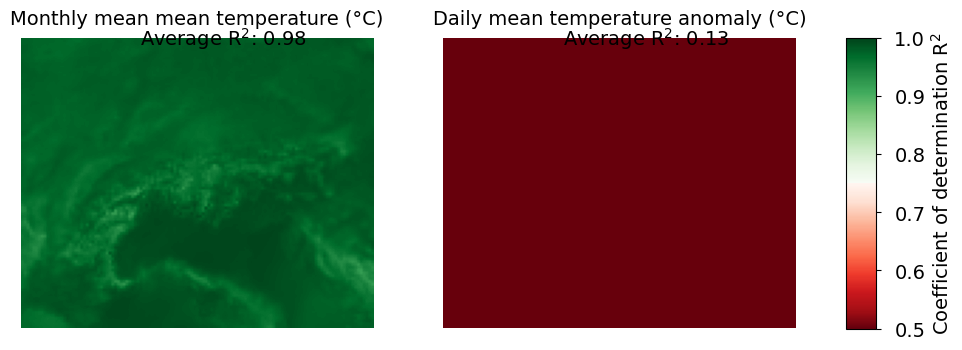

In [20]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0.5, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [21]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average bias of tasmean: 0.02°C


In [22]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average MAE of tasmean: 0.02°C


In [23]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average RMSE of tasmean: 0.03°C


In [24]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2016): 1.00
Yearly average Pearson correlation coefficient for tasmean: 1.00


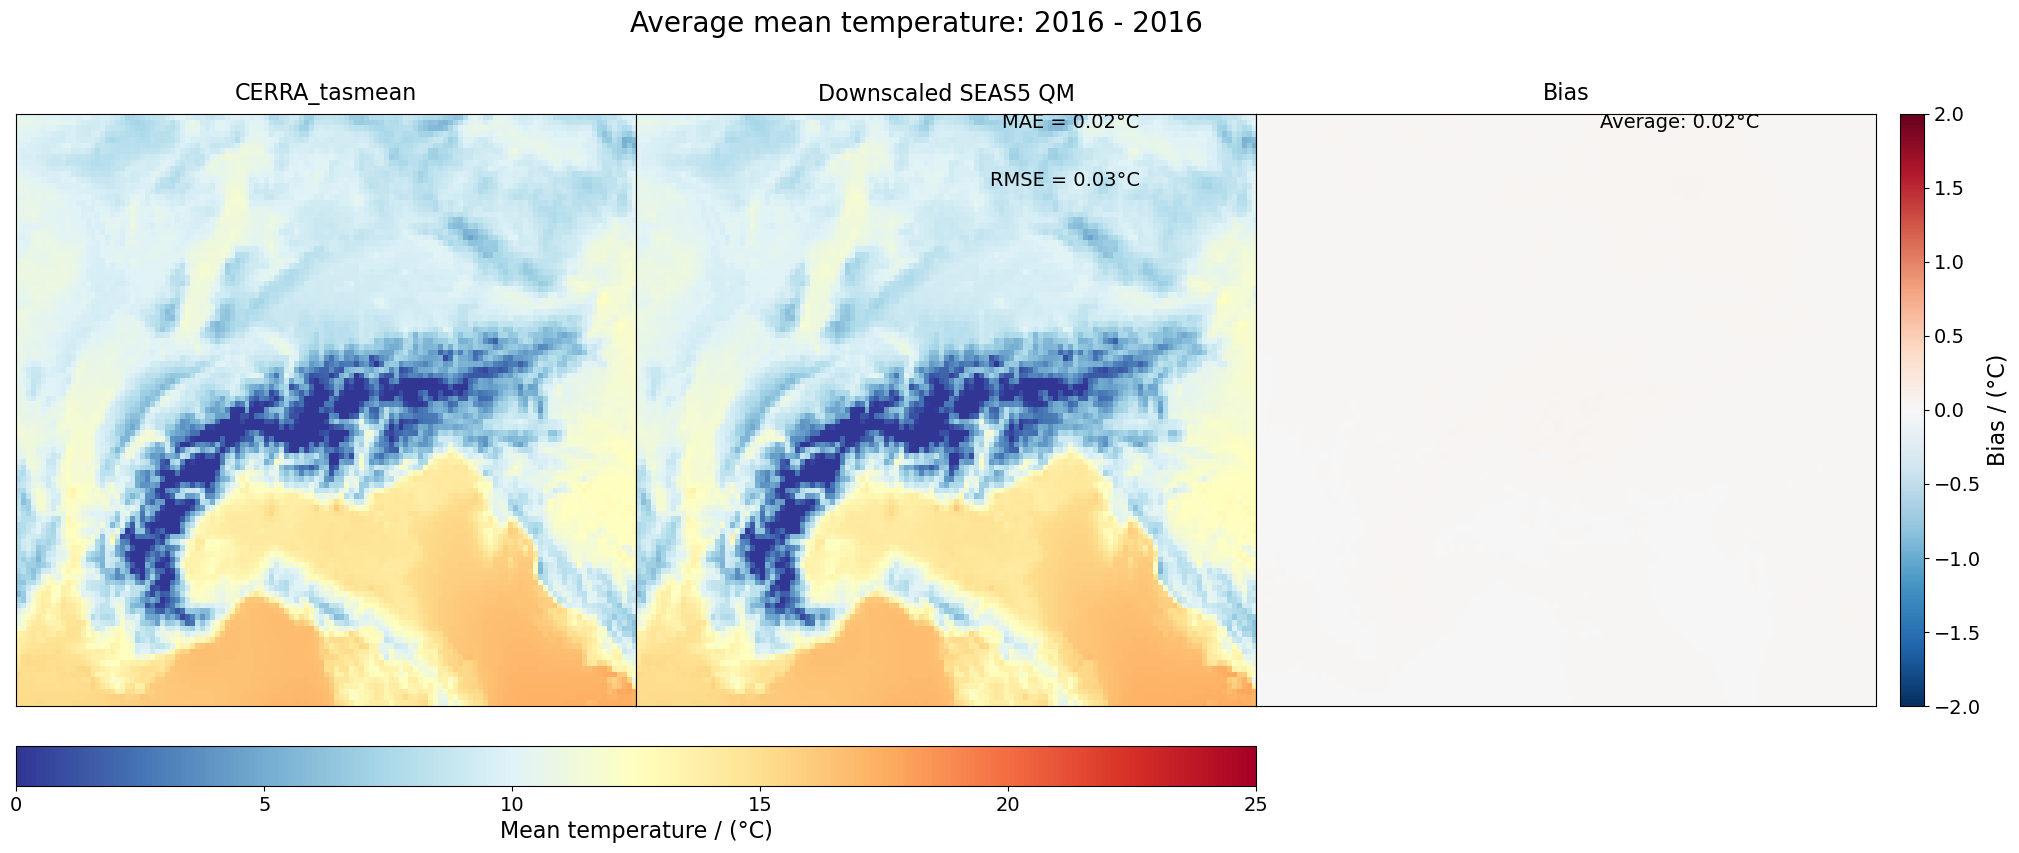

In [25]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [26]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [27]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Average bias of mean tasmean for season DJF: -1.0°C
(CERRA_tasmean:Downscaled SEAS5 QM) Average bias of mean tasmean for season JJA: 0.4°C
(CERRA_tasmean:Downscaled SEAS5 QM) Average bias of mean tasmean for season MAM: 0.4°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

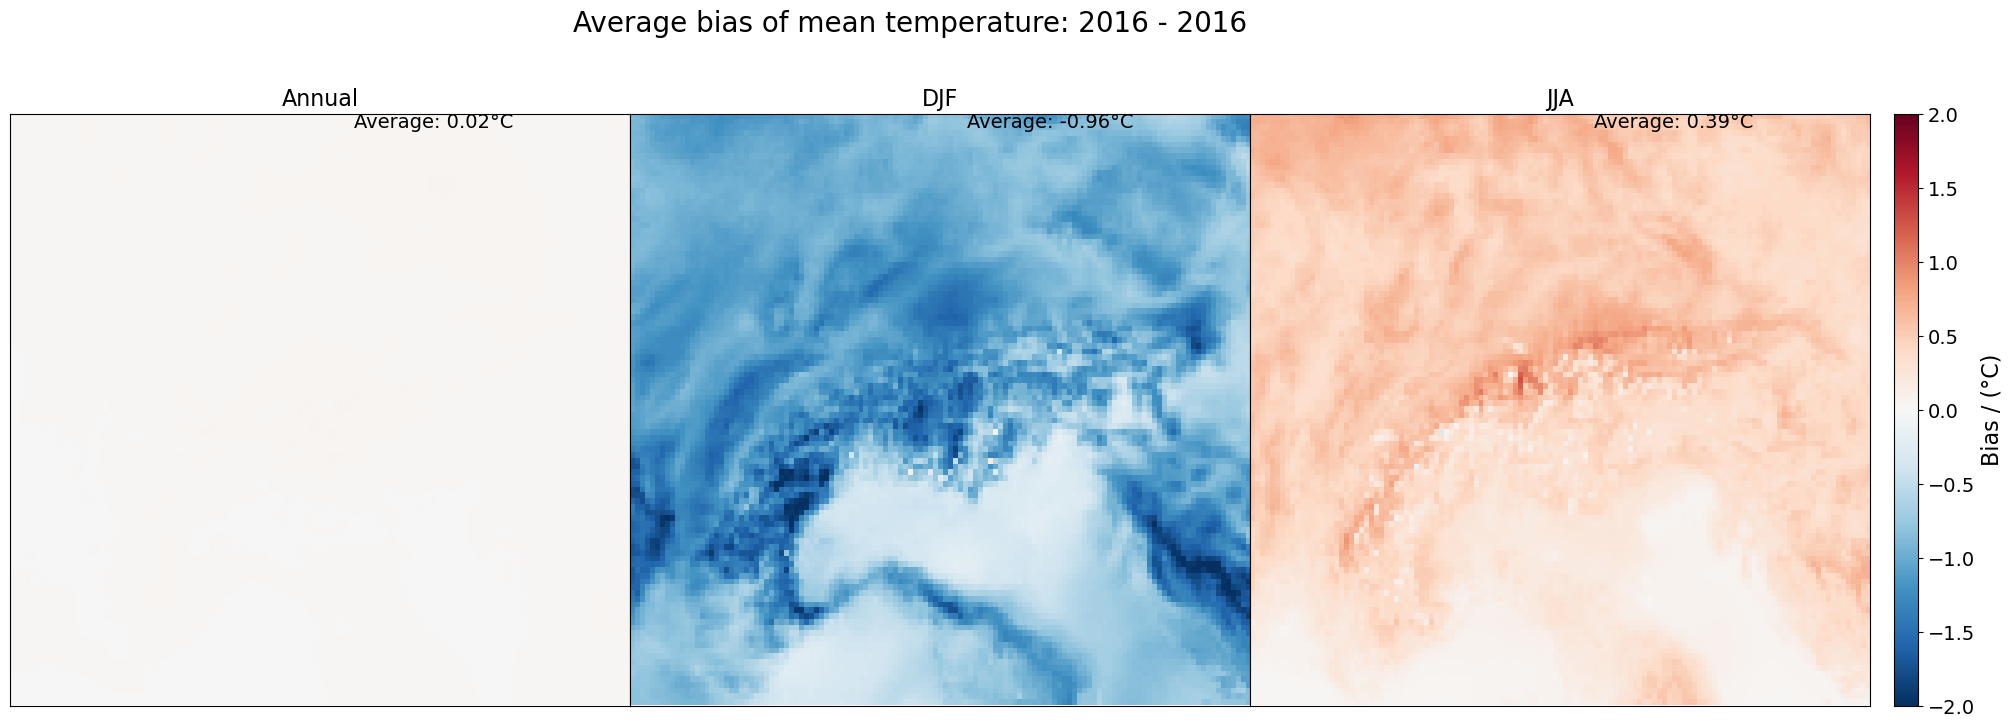

In [28]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [29]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [30]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [31]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [32]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average bias for P98 of tasmean: 0.0°C


In [33]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [34]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average MAE for P98 of tasmean: 0.0°C


In [35]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [36]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(CERRA_tasmean:Downscaled SEAS5 QM) Yearly average RMSE for P98 of tasmean: 0.0°C


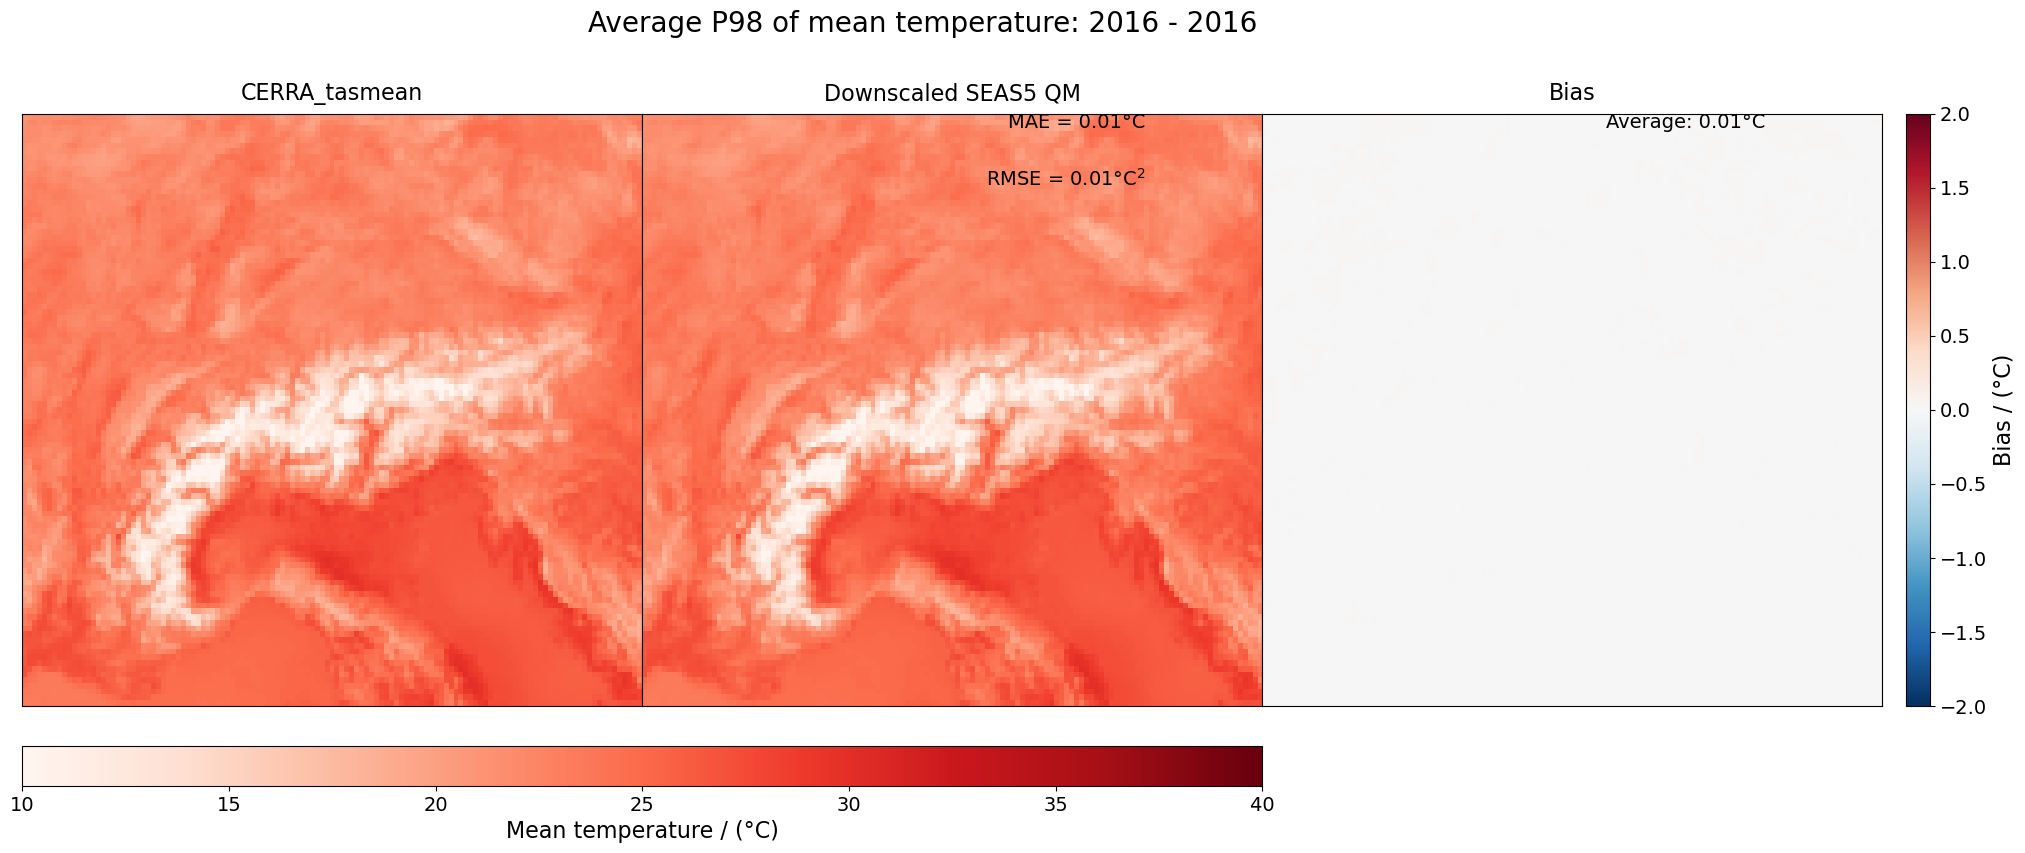

In [37]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

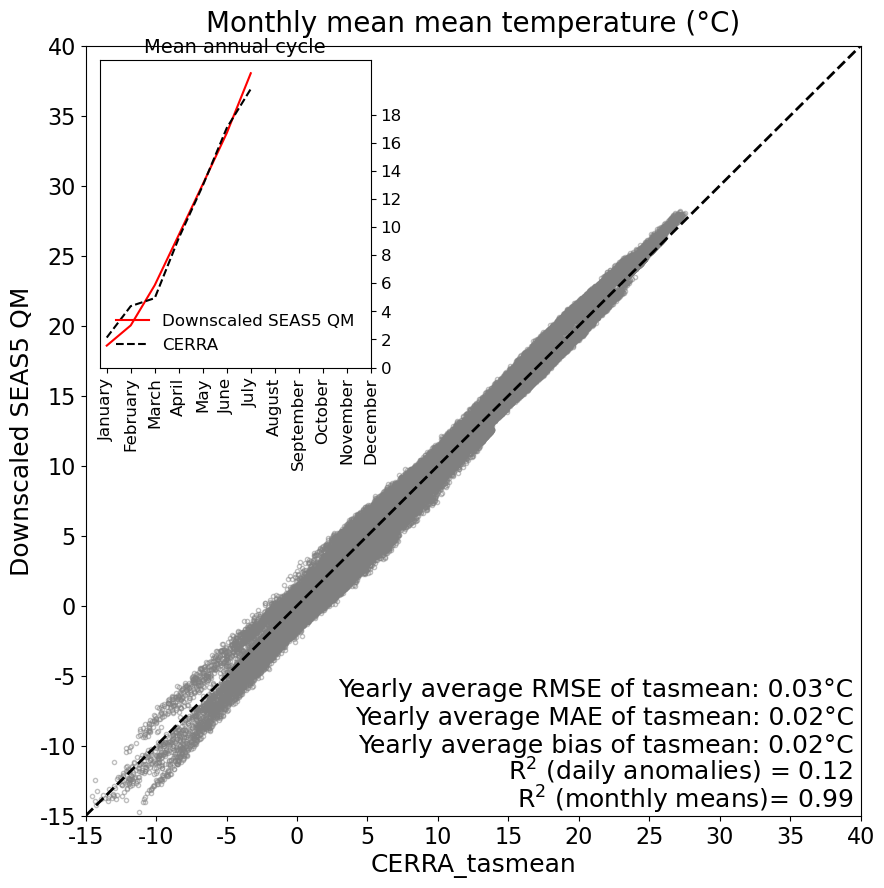

In [38]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
